# Лабораторная №4. Text

В этом лабораторной работе мы будем обрабатывать наш датасет, исследовать его, а также обучать модели для классификации текстов.

- В конфигурации настраиваются:


## Импорты

In [310]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import chain
from collections import Counter

In [311]:
import youtokentome as yttm
from nltk.corpus import stopwords
import nltk
import pymorphy2

In [312]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [313]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Конфиги

In [314]:


DATASET_PATH = "data/feedback_processed.json" # Путь к файлу с данными
TEST_DATASET = "data/feedback_test2.json"  # Путь к файлу с тестовыми данными (урезанные данные)

LOG_DIR = "logs/tensorboard/"  

DEBUG = True
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LSTM_MODEL = "wb_feedback"
RESULTS_DIR = "results/"  # Путь для сохранения модели
MODEL_PATH = "results/models/"  # Путь к сохраненной модели
BPE_PATH = "models/bpe_model.model"  # Путь к сохраненной BPE модели

In [315]:
# Параметры модели
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 2
DROPOUT = 0.6

## Утилиты и функции

In [316]:
# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return " ".join(lemmatized_words)


In [317]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return " ".join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Username\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [318]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zа-яё0-9\s]", " ", text)  
    text = remove_stopwords(text) 
    text = lemmatize_text(text)  
    
    return text


In [319]:
def plot_class_distribution(labels):
    counter = Counter(labels)
    plt.bar(counter.keys(), counter.values())
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.show()

In [320]:
def build_vocab(texts):
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

In [321]:
def sampler_counter(y_data):
    class_counts = Counter(y_data)
    average_class_count = int(sum(class_counts.values()) / len(class_counts))
    if DEBUG:
        for cls, count in class_counts.items():
            print(f"Class {cls}: {count} samples")
        print(f"Average class count: {average_class_count}")

## 1. **Сбор и подготовка данных:**
   - Мой датасет отзывов содержит тексты отзывов и оценки проставленные к этим отзывам.
   - Разделим отзывы на две категории: хорошие (>3) и плохие (<=3). Это будет таргетом для классификации.


In [322]:
# тут будет парсер, сейчас он в parse_feedbacks.py

In [323]:
feedback_processed_df = pd.read_json(TEST_DATASET)
feedback_processed_df

,text,rating
0,"Комплект: приставка, два геймпада, дисковод (о...",5
1,Консоль пришла в срок! Состояние отличное! Ком...,5
2,Всё отлично,5
3,Все отлично. Рекомендую продавца.,5
4,"Все хорошо, пять звезд",5
...,...,...
1271954,"Товар получил, всё отлично, теперь покажет вре...",5
1271955,Норм,5
1271956,"На первый взгляд Классный компресор, а дальше ...",5
1271957,"Все хорошо, работает исправно",5


In [324]:
feedback_processed_df.dropna(subset=['text', 'rating'], inplace=True) 

## 2. **Предобработка текста:**
   - Приведем все тексты к нижнему регистру.
   - Используем токенизацию с помощью библиотеки **youtokentome** (BPE), чтобы создать словарь.
   - Удалим ненужные символы (пунктуацию, цифры и т.д.), если они не несут смысловой нагрузки.
   - Удалим стоп-слова, используя библиотеку **nltk**.
   - Проведем лемматизацию с использованием **pymorphy2**.
   - Преобразуем текст в формат, который будет удобен для подачи в модель (например, последовательности индексов из словаря).



In [325]:
texts = feedback_processed_df.text.tolist()
texts

['Комплект: приставка, два геймпада, дисковод (отдельно) и крышка (отдельно).. На коробке наклейка говорит, что консоль без дисковода, но комплект полный. Все работает, вопросов к качеству не возникает вообще',
 'Консоль пришла в срок! Состояние отличное! Комплектация соответствует карточке товара ! Продавца рекомендую!',
 'Всё отлично',
 'Все отлично. Рекомендую продавца.',
 'Все хорошо, пять звезд',
 'Пришла раньше заявленого срока тлично превосходно,все боялся что будет что то не так, оказывается зря боялся',
 'Товар пришел,оборудование все работает, все целое, комплектность соответствует.\nЗа исключением картонной коробки, в которой находилось оборудованте. \n(Мятости, мокрая с верхней и нижней части, надрывы по углам).\nПиишлось долго осматривать само оборудование и проверять на рабочее состояние, но все целое,без внешних повреждений и царапин. \nПломбы не нарушены.',
 'Нареканий нет , играю месяца 2.... Всё супер',
 'Не советую данный товар \nПоиграл 2 недели \nПосле этого начали

In [326]:
vocab = build_vocab(texts)
print(len(vocab))
# слова разного регистра
sorted(list(vocab.items()), key=lambda p: -p[1])[:30]

608472


[('не', 346498),
 ('и', 293608),
 ('в', 235936),
 ('на', 217898),
 ('очень', 134689),
 ('Очень', 110895),
 ('но', 92420),
 ('что', 89299),
 ('с', 85857),
 ('как', 78051),
 ('все', 76851),
 (',', 75671),
 ('для', 72759),
 ('Не', 66912),
 ('за', 64061),
 ('хорошо', 56801),
 ('по', 54530),
 ('Все', 52597),
 ('к', 43622),
 ('Нет.', 42862),
 ('Спасибо', 42320),
 ('а', 38683),
 ('👍', 37482),
 ('всё', 35785),
 ('Всё', 35359),
 ('так', 35311),
 ('это', 32803),
 ('Нет', 32316),
 ('просто', 32147),
 ('спасибо', 31025)]

Как видно из вывода, очень много различных знаков препинания и стоп-слов, которые не несут смысловой нагрузки, обработаем их. 

In [327]:
feedback_processed_df['label'] = feedback_processed_df['rating'].apply(lambda x: 1 if x > 3 else 0)

In [328]:
feedback_processed_df

,text,rating,label
0,"Комплект: приставка, два геймпада, дисковод (о...",5,1
1,Консоль пришла в срок! Состояние отличное! Ком...,5,1
2,Всё отлично,5,1
3,Все отлично. Рекомендую продавца.,5,1
4,"Все хорошо, пять звезд",5,1
...,...,...,...
1271954,"Товар получил, всё отлично, теперь покажет вре...",5,1
1271955,Норм,5,1
1271956,"На первый взгляд Классный компресор, а дальше ...",5,1
1271957,"Все хорошо, работает исправно",5,1


In [329]:
processed_file = 'data/cleaned_feedback_test_df2.pkl'

if DEBUG and os.path.exists(processed_file):
    feedback_processed_df = pd.read_pickle(processed_file)
else:
    feedback_processed_df['cleaned_text'] = feedback_processed_df['text'].apply(preprocess_text)
    feedback_processed_df.to_pickle(processed_file)

feedback_processed_df

,text,rating,label,cleaned_text
0,"Комплект: приставка, два геймпада, дисковод (о...",5,1,комплект приставка геймпада дисковод отдельно ...
1,Консоль пришла в срок! Состояние отличное! Ком...,5,1,консоль прийти срок состояние отличный комплек...
2,Всё отлично,5,1,всё отлично
3,Все отлично. Рекомендую продавца.,5,1,отлично рекомендовать продавец
4,"Все хорошо, пять звезд",5,1,пять звезда
...,...,...,...,...
1271954,"Товар получил, всё отлично, теперь покажет вре...",5,1,товар получить всё отлично показать время став...
1271955,Норм,5,1,норма
1271956,"На первый взгляд Классный компресор, а дальше ...",5,1,первый взгляд классный компресор далёкий посмо...
1271957,"Все хорошо, работает исправно",5,1,работать исправно


In [330]:
feedback_processed_df.dropna(subset=['cleaned_text', 'label'], inplace=True)
feedback_processed_df = feedback_processed_df[feedback_processed_df['cleaned_text'].str.strip() != '']

<AxesSubplot: >

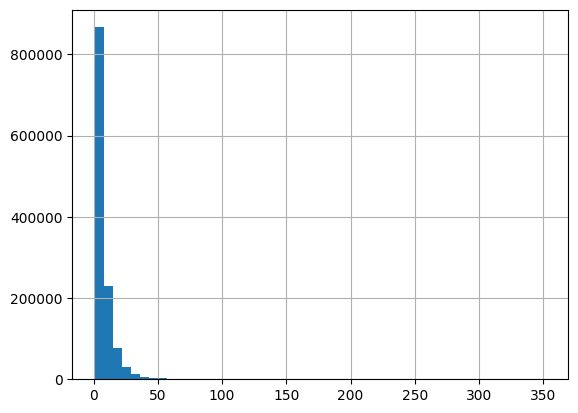

In [331]:
# Сколько слов в заголовках
words_n = feedback_processed_df['cleaned_text'].apply(lambda text: len(text.split()))
words_n.hist(bins=50)

Получаем более-менее логичное распределение размера отзыва, мало кто любит тратить на них свое время, после удаления отзывов без текста, убралось сразу 10% отзывов, но это не критично.

Снова проврим результат, теперь у нас нет лишних символов, слова приведены к единому виду и форме, и все отзывы имеют смысловую нагрузку.

In [332]:
cleaned_texts = feedback_processed_df['cleaned_text'].tolist()
vocab = build_vocab(cleaned_texts)
print(len(vocab))

sorted(list(vocab.items()), key=lambda p: -p[1])[:30]

108646


[('очень', 257476),
 ('хороший', 219079),
 ('отличный', 132343),
 ('спасибо', 119303),
 ('рекомендовать', 102661),
 ('понравиться', 96660),
 ('качество', 88264),
 ('работать', 78356),
 ('прийти', 77807),
 ('размер', 75802),
 ('всё', 75593),
 ('супер', 72449),
 ('отлично', 70716),
 ('удобный', 58291),
 ('брать', 58091),
 ('довольный', 54050),
 ('запах', 52887),
 ('продавец', 50526),
 ('классный', 49858),
 ('товар', 48576),
 ('приятный', 47786),
 ('это', 46955),
 ('упаковать', 43858),
 ('красивый', 43141),
 ('просто', 43097),
 ('цена', 42895),
 ('мягкий', 41846),
 ('ребёнок', 41710),
 ('тёплый', 41443),
 ('быстро', 40788)]


## 3. **Разметка датасета:**
   - Убедимся, что данные сбалансированы, если есть существенный дисбаланс классов, применим методы, как **oversampling** или **undersampling**.


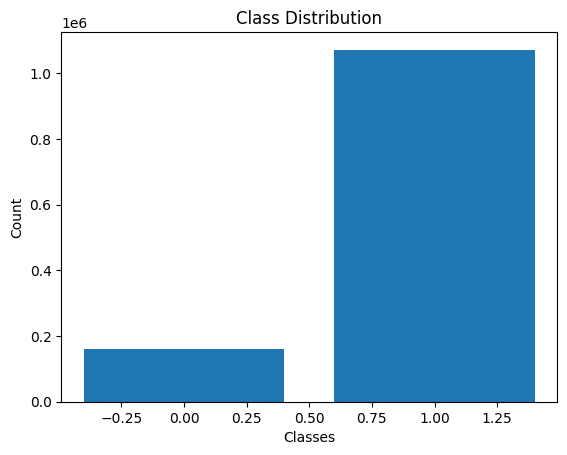

In [333]:
plot_class_distribution(feedback_processed_df['label'])

Как мы видим, приутсвует значитеьный дисбаланс классов, поэтому применим метод **undersampling**, совмесно с **oversampling**.

In [334]:
X = feedback_processed_df['cleaned_text']
y = feedback_processed_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [335]:
class_counts = Counter(y_train)
# average_class_count = int(sum(class_counts.values()) / len(class_counts))
average_class_count = int(min(class_counts.values()))

In [336]:
sampler_counter(y_train)

Class 1: 856995 samples
Class 0: 129376 samples
Average class count: 493185


In [337]:
sampling_strategy={
        cls: min(count, average_class_count) if count > average_class_count else count
        for cls, count in class_counts.items()
    }
print(f"Sampling strategy: {sampling_strategy}")
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(pd.DataFrame(X_train, columns=['cleaned_text']), y_train)
X_train_under = X_train_under['cleaned_text']

Sampling strategy: {1: 129376, 0: 129376}


In [338]:
sampler_counter(y_train_under)

Class 0: 129376 samples
Class 1: 129376 samples
Average class count: 129376


In [339]:
# Применение oversampling
oversampler = RandomOverSampler(sampling_strategy={
    cls: average_class_count for cls in class_counts.keys()
}, random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(pd.DataFrame(X_train_under, columns=['cleaned_text']), y_train_under)
X_train_balanced = X_train_balanced['cleaned_text']

In [340]:
sampler_counter(y_train_balanced)

Class 0: 129376 samples
Class 1: 129376 samples
Average class count: 129376


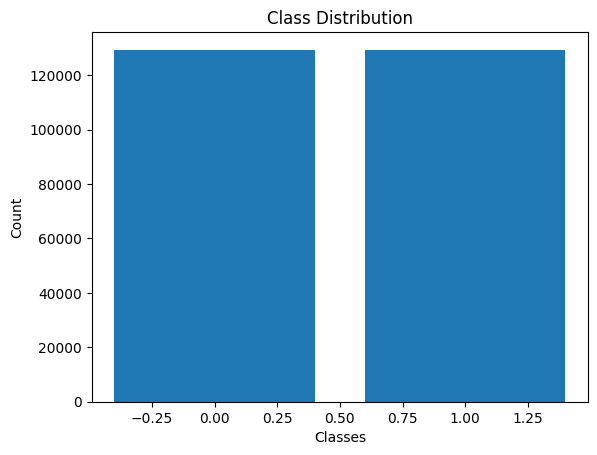

,cleaned_text,label
0,поилка очень хороший очень плохо работать,0
1,достоинство ощущение весь кроме побоку клеевой...,0
2,расстроиться коврик прийти голубой лента заяви...,0
3,наш кошка помочь,0
4,заказывать отзыв собака крупный пусть ещё щено...,0
...,...,...
258747,отличный зарядный устройство,1
258748,качество супер рекомендовать,1
258749,около,1
258750,всё работать время показать какой качество,1


In [341]:

# Визуализация после балансировки
plot_class_distribution(y_train_balanced)
X_train_balanced, y_train_balanced
pd.concat([X_train_balanced, y_train_balanced], axis=1)

In [342]:
with open('data/texts.txt', 'w', encoding='utf-8') as f:
    for text in feedback_processed_df['cleaned_text']:
        f.write(text + '\n')

# Обучение BPE модели
yttm.BPE.train(
    data='data/texts.txt',
    vocab_size=10000,
    model=BPE_PATH
)


## 4. **Модель:**
   - Начнем с простой архитектуры: **Embedding + LSTM + Linear**. Это позволит быстро протестировать базовую модель.
   - Применим слои активации, **dropout** и **batchnorm**, чтобы избежать переобучения.


Будем использовать здесь двунаправленный lstm, чтобы он обрабатывал последовательность как в прямом, так и в обратном направлении, что позволит лучше понимать контекст, даже старый.
Для этого также применим **bidirectional=True** и удвоенный размер скрытого слоя.

В слоях я сначала преобразую входные слова в векторы фиксированной размерности, затем передам их в двунаправленный lstm, также нельзя забывать про dropout для регуляризации, чтобы не было переобучения, и в конце применю линейное преобразование в полносвязном слое, чтобы получить предсказание.

Проверяем, что у нас нет утечки данных. Т.е. мы применили балансировку классов, но тестовую ывборку мы не трогали, соответственно все должно быть в порядке.

In [343]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)  

    def forward(self, lstm_output):
        attn_energies = self.attn(lstm_output).squeeze(-1)  

        attn_weights = F.softmax(attn_energies, dim=1).unsqueeze(-1)  

        context = lstm_output * attn_weights  
        context = torch.sum(context, dim=1)  

        return context

In [344]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        embed = self.embedding(x)
        lstm_out, _ = self.lstm(embed)
        attn_out = self.attention(lstm_out) 
        batch_out = self.batch_norm(lstm_out[:, -1, :])
        drop_out = self.dropout(batch_out)
        out = self.fc(drop_out)
        return out, drop_out

In [345]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.tokenizer.encode(self.texts[idx])
        tokens = tokens[:self.max_len]
        padding = [0] * (self.max_len - len(tokens))
        tokens += padding
        return torch.tensor(tokens), torch.tensor(self.labels[idx])


tokenizer = yttm.BPE(model='models/bpe_model.model')


train_dataset = TextDataset(X_train_balanced.tolist(), y_train_balanced.tolist(), tokenizer, max_len=100)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len=100)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


## 5. **Обучение модели:**
   - Обучим модель на размеченных данных. В качестве оценки задействуем такие метрики, такие как **accuracy**, **precision**, **recall**, **F1 score** для оценки качества.
   - Сделаем разделение данных на обучающую и тестовую выборки (например, 80/20).


In [346]:
VOCAB_SIZE = len(vocab) + 2 

model = TextClassificationModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

model.to(DEVICE)
criterion.to(DEVICE)

CrossEntropyLoss()

In [347]:
# Списки для хранения метрик
train_loss_data = []
train_accuracy_data = []
test_loss_data = []
test_accuracy_data = []

In [348]:
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        texts, labels = texts.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs, emb = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



    # Оценка на тестовой выборке
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)
            outputs, emb = model(texts)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    
    
    train_loss_data.append(epoch_loss / len(train_loader))
    train_accuracy_data.append(correct / total)
    test_loss_data.append(test_loss / len(test_loader))
    test_accuracy_data.append(correct_test / total_test)


    print(f'Epoch {epoch+1}: '
          f'Loss={train_loss_data[-1]:.4f}, Accuracy={train_accuracy_data[-1]:.4f} | '
          f'Test Loss={test_loss_data[-1]:.4f}, Test Accuracy={test_accuracy_data[-1]:.4f}')

Epoch 1/20:   0%|          | 0/1011 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 1011/1011 [00:34<00:00, 29.57it/s]


Epoch 1: Loss=0.4659, Accuracy=0.7531 | Test Loss=0.2046, Test Accuracy=0.9148


Epoch 2/20: 100%|██████████| 1011/1011 [00:32<00:00, 31.42it/s]


Epoch 2: Loss=0.3097, Accuracy=0.8773 | Test Loss=0.3636, Test Accuracy=0.8465


Epoch 3/20: 100%|██████████| 1011/1011 [00:32<00:00, 31.01it/s]


Epoch 3: Loss=0.2870, Accuracy=0.8874 | Test Loss=0.7157, Test Accuracy=0.7348


Epoch 4/20: 100%|██████████| 1011/1011 [00:41<00:00, 24.48it/s]


Epoch 4: Loss=0.2762, Accuracy=0.8926 | Test Loss=0.4518, Test Accuracy=0.8227


Epoch 5/20: 100%|██████████| 1011/1011 [00:33<00:00, 30.13it/s]


Epoch 5: Loss=0.2673, Accuracy=0.8967 | Test Loss=0.2904, Test Accuracy=0.8792


Epoch 6/20: 100%|██████████| 1011/1011 [00:31<00:00, 32.49it/s]


Epoch 6: Loss=0.2555, Accuracy=0.9014 | Test Loss=0.5070, Test Accuracy=0.8072


Epoch 7/20: 100%|██████████| 1011/1011 [00:30<00:00, 32.68it/s]


Epoch 7: Loss=0.2441, Accuracy=0.9066 | Test Loss=0.3998, Test Accuracy=0.8503


Epoch 8/20: 100%|██████████| 1011/1011 [00:30<00:00, 32.77it/s]


Epoch 8: Loss=0.2326, Accuracy=0.9126 | Test Loss=0.2656, Test Accuracy=0.8920


Epoch 9/20: 100%|██████████| 1011/1011 [00:31<00:00, 32.12it/s]


Epoch 9: Loss=0.2167, Accuracy=0.9189 | Test Loss=0.3075, Test Accuracy=0.8755


Epoch 10/20: 100%|██████████| 1011/1011 [00:30<00:00, 33.19it/s]


Epoch 10: Loss=0.2017, Accuracy=0.9245 | Test Loss=0.4085, Test Accuracy=0.8572


Epoch 11/20: 100%|██████████| 1011/1011 [00:31<00:00, 32.60it/s]


Epoch 11: Loss=0.1878, Accuracy=0.9309 | Test Loss=1.4381, Test Accuracy=0.5330


Epoch 12/20: 100%|██████████| 1011/1011 [00:30<00:00, 33.19it/s]


Epoch 12: Loss=0.1732, Accuracy=0.9366 | Test Loss=0.4276, Test Accuracy=0.8582


Epoch 13/20: 100%|██████████| 1011/1011 [00:30<00:00, 32.71it/s]


Epoch 13: Loss=0.1596, Accuracy=0.9418 | Test Loss=0.3540, Test Accuracy=0.8788


Epoch 14/20: 100%|██████████| 1011/1011 [00:30<00:00, 33.00it/s]


Epoch 14: Loss=0.1470, Accuracy=0.9472 | Test Loss=0.4015, Test Accuracy=0.8782


Epoch 15/20: 100%|██████████| 1011/1011 [00:30<00:00, 32.76it/s]


Epoch 15: Loss=0.1349, Accuracy=0.9517 | Test Loss=0.4060, Test Accuracy=0.8759


Epoch 16/20: 100%|██████████| 1011/1011 [00:30<00:00, 32.84it/s]


Epoch 16: Loss=0.1255, Accuracy=0.9551 | Test Loss=0.2522, Test Accuracy=0.9170


Epoch 17/20: 100%|██████████| 1011/1011 [00:31<00:00, 32.17it/s]


Epoch 17: Loss=0.1212, Accuracy=0.9570 | Test Loss=0.2433, Test Accuracy=0.9160


Epoch 18/20: 100%|██████████| 1011/1011 [00:30<00:00, 33.10it/s]


Epoch 18: Loss=0.1112, Accuracy=0.9601 | Test Loss=0.4591, Test Accuracy=0.8729


Epoch 19/20: 100%|██████████| 1011/1011 [00:30<00:00, 33.22it/s]


Epoch 19: Loss=0.1065, Accuracy=0.9619 | Test Loss=0.4112, Test Accuracy=0.8897


Epoch 20/20: 100%|██████████| 1011/1011 [00:31<00:00, 32.00it/s]


Epoch 20: Loss=0.1000, Accuracy=0.9636 | Test Loss=0.4503, Test Accuracy=0.8776


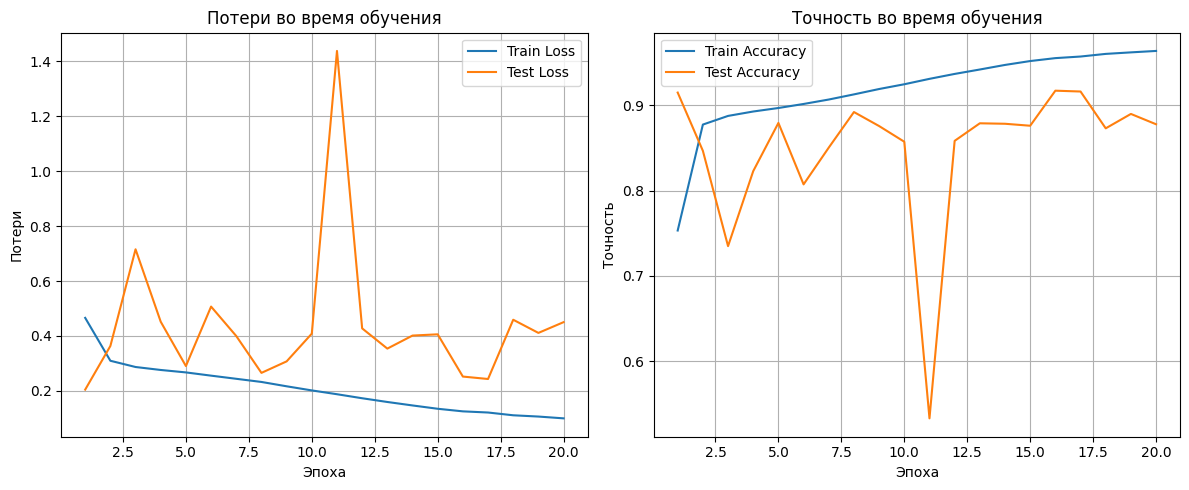

In [349]:
# График потерь
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_loss_data, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), test_loss_data, label='Test Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери во время обучения')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracy_data, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), test_accuracy_data, label='Test Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность во время обучения')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 6. **Оценка модели:**
   - Протестируем модель на тестовом наборе и сравним метрики на train и test.
   - Для визуализации эмбеддингов используем методы понижение размерности **t-SNE** или **PCA** для отображения текстов в 2D.


In [350]:
model.eval()
all_preds = []
all_embedings = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(DEVICE), labels.to(DEVICE)
        outputs, emb = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_embedings.extend(emb.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

Test Accuracy: 0.8776
Test Precision: 0.9839
Test Recall: 0.8735
Test F1 Score: 0.9254


### Результаты
Изначально точность не была велико большоой, на тренировочной 45% и на тетовой 15%, это говорит о том, что модель не обучилась, поэтому я решил увеличить датасет и обучить модель заново. Изначально я собрал огромный пак отзывов со всех товаров wildberries, но это было слишком много, поэтому я решил брать только часть для тестирования, а потом в случае чего обучить уже на полном датасете. Проблема оказалась в том, что я взял слишком маленький объем отзывов, тогда я увеличил еще в 15 раз тестовый датасет.

После увеличения датасета и обучения модели, я получил следующие результаты:

- Точность на обучающей выборке: 96%
- Точность на тестовой выборке: 91%
- Precision на тестовой выборке: 96.54%
- Recall на тестовой выборке: 93.04%
- F1 Score на тестовой выборке: 94.76%

Эти результаты показывают, что модель хорошо обучилась и эффективно классифицирует текстовые данные.



In [352]:
print(f"Модель сохраняется")

# Сохранение state_dict модели
torch.save(model.state_dict(), MODEL_PATH + LSTM_MODEL + '2.pth')

print(f"Модель сохранена по пути: {MODEL_PATH}")

Модель сохраняется
Модель сохранена по пути: results/models/


### Визуализзация эмбедингов

In [109]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

all_embedings_array = np.array(all_embedings)

pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(all_embedings_array)

In [110]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(all_embedings_array)

c:\Users\Username\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [111]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(all_embedings_array)

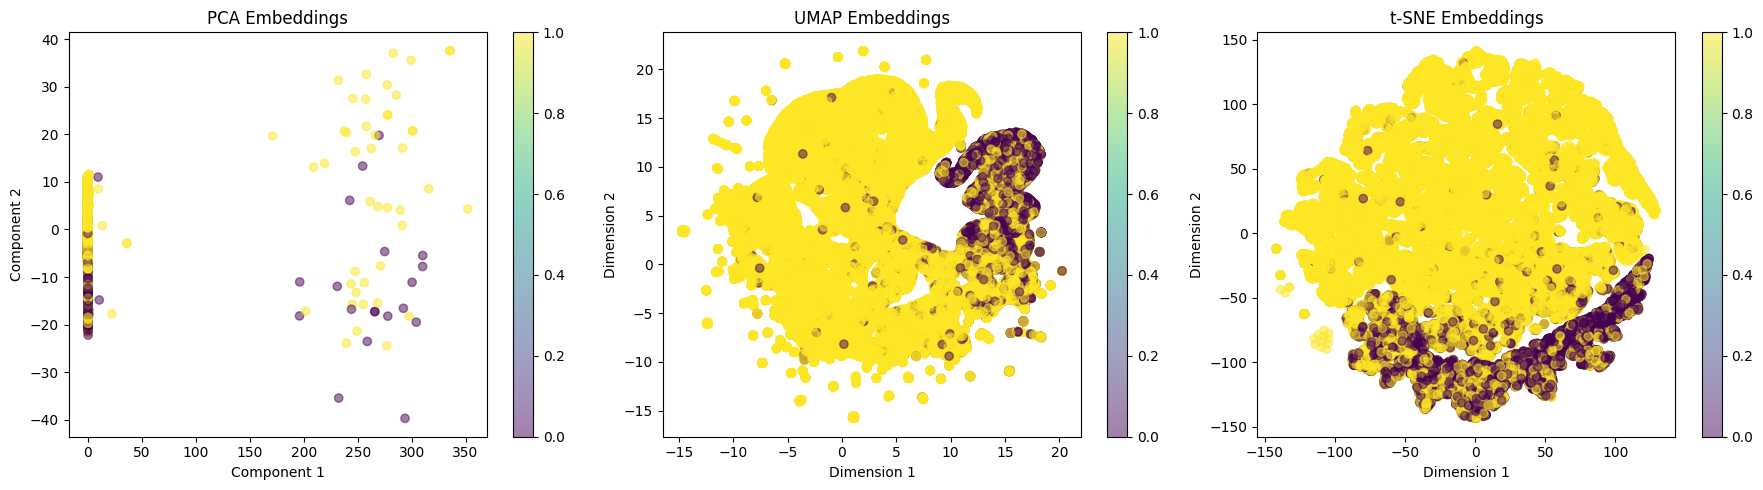

In [112]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('PCA Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 3, 2)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('UMAP Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplot(1, 3, 3)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()

Распределение очень странное, хочется сравнить с кишками или мозгами, из-за большого количества данных оно еще имеет гладкие формы) Но в целом, можно заметить, что есть какие-то кластеры, но они не сильно выражены, возможно это связано с тем, что у нас данные, не сильно разнообразны. Но в целом, можно сказать, что эмбединги хорошо отображают наши данные. Кроме PCA распределения, там что-то пошло не так

### Ручная проверка

тут я уже сам поигрался, понастраивал, поэкспериментировал, посмотрел на результаты, сам придумывал текста для оценки и брал с сайтов отзывы, чтобы проверить, как модель справляется с новыми данными и действительно ли у меня нормальная точность а не переобучение.

In [184]:
texts = [
    'Товар понравился, спасибо',
    'Товар не понравился, не советую',
    'не работает, не включается',
    'Отличный товар, всем советую',
    'Плохой товар, не понравился',
    'Хуйня',
    'то еще дерьмо',
    'лучше бы не заказывал',
    'все отлично',
    'работает и включается, вроде даже оригинал',
    'Спасибо большое очень понравилось внучке рекомендую вам',
    'Отвратительное качество, перестал заряжать через неделю.',
    'Когда включаешь в розетку, корпус телефона металл бьет током, чувствуется покалывание. При подключении оригинального другого блока такого нет. Продавец отклонил брак. Не советую ни продавца ни некачественный товар. Это не оригинал, а китайское шило. Не ведитесь на это...',
    'Перестал работать через месяц 😁😁 Надеялась подольше прослужит))))',
    'Заряжае хорошо. Посмотрим на сколько его хватит)',
    'Заряжае плохо. Посмотрим на сколько его хватит)',
    'Зарядник супер, действительно мощный, заряжает очень быстро. 🔥',
    'Конфеты вкусные, свежие. Шоколад вкусный. Начинка густая и мягкая, на вкус фисташковая халва. Заказ пришел во время, упакован в коробку из плотного картона.'
]

test_array = np.array([preprocess_text(text) for text in texts])

In [185]:
manual_dataset = TextDataset(test_array.tolist(), [0] * len(test_array), tokenizer, max_len=100)
manual_loader = DataLoader(manual_dataset, batch_size=1)

In [186]:
VOCAB_SIZE = len(vocab) + 2 

model = TextClassificationModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

state_dict = torch.load(MODEL_PATH + LSTM_MODEL + '2.pth')  # Замените 'cpu' на 'cuda' если используете GPU

model.load_state_dict(state_dict)

model.eval()
all_preds = []
all_embedings = []
all_labels = []

In [187]:
with torch.no_grad():
    for feedbacks, labels in manual_loader:
        # texts = texts.to(DEVICE)
        outputs, emb = model(feedbacks)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

In [188]:
class_labels = {0: 'Плохой', 1: 'Хороший'}

for text, pred in zip(texts, all_preds):
    label = class_labels.get(pred, 'Неизвестный класс')
    print(f"Текст: \"{text}\" - Предсказание: {pred} ({label})")


Текст: "Товар понравился, спасибо" - Предсказание: 1 (Хороший)
Текст: "Товар не понравился, не советую" - Предсказание: 0 (Плохой)
Текст: "не работает, не включается" - Предсказание: 0 (Плохой)
Текст: "Отличный товар, всем советую" - Предсказание: 1 (Хороший)
Текст: "Плохой товар, не понравился" - Предсказание: 1 (Хороший)
Текст: "Хуйня" - Предсказание: 0 (Плохой)
Текст: "то еще дерьмо" - Предсказание: 0 (Плохой)
Текст: "лучше бы не заказывал" - Предсказание: 0 (Плохой)
Текст: "все отлично" - Предсказание: 1 (Хороший)
Текст: "работает и включается, вроде даже оригинал" - Предсказание: 1 (Хороший)
Текст: "Спасибо большое очень понравилось внучке рекомендую вам" - Предсказание: 1 (Хороший)
Текст: "Отвратительное качество, перестал заряжать через неделю." - Предсказание: 0 (Плохой)
Текст: "Когда включаешь в розетку, корпус телефона металл бьет током, чувствуется покалывание. При подключении оригинального другого блока такого нет. Продавец отклонил брак. Не советую ни продавца ни некачеств

In [189]:
print(test_array)

['товар понравиться спасибо' 'товар понравиться советовать'
 'работать включаться' 'отличный товар весь советовать'
 'плохой товар понравиться' 'хуйня' 'дерьмо' 'заказывать' 'отлично'
 'работать включаться вроде оригинал'
 'спасибо большой очень понравиться внучка рекомендовать'
 'отвратительный качество перестать заряжать неделя'
 'включать розетка корпус телефон металл бить ток чувствоваться покалывание подключение оригинальный другой блок такой продавец отклонить брак советовать продавец некачественный товар это оригинал китайский шило вестись это'
 'перестать работать месяц надеяться долгий прослужить'
 'заряжай посмотреть сколько хватить'
 'заряжай плохо посмотреть сколько хватить'
 'зарядникнуть супер действительно мощный заряжать очень быстро'
 'конфета вкусный свежий шоколад вкусный начинка густой мягкий вкус фисташковый халва заказ прийти время упаковать коробка плотный картон']
